In [1]:
import glob

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import longer_than_exwl
from CCfun  import find_crystal_position
from CCfun  import compute_baseline_between

from CCplot import auto_plot_style

from CCdatabase import californication_irradiation_mapping
from CCdatabase import position_correction

from CCio import load_all

In [2]:
%matplotlib inline

auto_plot_style({"lines.linewidth": 2})

In [3]:
%load_ext autoreload
%autoreload 2

# All data

In [4]:
filenames_pre  = glob.glob("/home/gonzalo/data/CC/Californication/*pre*.h5")
filenames_post = glob.glob("/home/gonzalo/data/CC/Californication/*post*.h5")
experiment     = load_all(filenames_pre, filenames_post)

In [5]:
experiment.pre.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        4        2          0        1000    114       0.1   
1       False        4        2          0        1000    114       0.1   
2       False        4        2          0        1000    114       0.1   
3       False        4        2          0        1000    114       0.1   
4       False        4        2          0        1000    114       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub   rate  \
0  275.0  0.000008  287.75    3251  Sp_B2_036           Sp   -26.0 -260.0   
1  275.0  0.000008  288.25    3207  Sp_B2_036           Sp   -70.0 -700.0   
2  275.0  0.000008  288.75    3276  Sp_B2_036           Sp    -1.0  -10.0   
3  275.0  0.000008  289.50    3273  Sp_B2_036           Sp    -4.0  -40.0   
4  275.0  0.000008  290.00    3290  Sp_B2_036           Sp    13.0  130.0   

        quantar       dquanta  wheel_no  
0  1.105275e+15 -2.352357e-13         0  
1  1.105275e+15 -6.333268e-13         0  
2  1.105275e+15 -9.047526e-15         0  
3  1.105275e+15 -3.619010e-14         0  
4  1.105275e+15  1.176178e-13         0

In [6]:
experiment.post.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        5        2          0        1000    114       0.1   
1       False        5        2          0        1000    114       0.1   
2       False        5        2          0        1000    114       0.1   
3       False        5        2          0        1000    114       0.1   
4       False        5        2          0        1000    114       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub    rate  \
0  275.0  0.000008  287.75    3396  Sp_B2_036           Sp   111.0  1110.0   
1  275.0  0.000008  288.25    3380  Sp_B2_036           Sp    95.0   950.0   
2  275.0  0.000008  288.75    3373  Sp_B2_036           Sp    88.0   880.0   
3  275.0  0.000008  289.50    3410  Sp_B2_036           Sp   125.0  1250.0   
4  275.0  0.000008  290.00    3379  Sp_B2_036           Sp    94.0   940.0   

        quantar       dquanta  wheel_no  
0  1.058061e+15  1.049089e-12         3  
1  1.058061e+15  8.978692e-13         3  
2  1.058061e+15  8.317104e-13         3  
3  1.058061e+15  1.181407e-12         3  
4  1.058061e+15  8.884179e-13         3

In [7]:
baseline_ranges = {"Sp250" : ( 850,  860),
                   "Qz250" : ( 890,  900),
                   "CaF600": (1000, 1010),
                   "CaF400": (1100, 1110),
                   "CaF350": (1050, 1060),
                   "BaF250": ( 650,  660),
                  }

In [8]:
def do_fit(x, y, key, *args, **kwargs):
    seed = y.max() - y.min(), peaks[key], 30, np.median(y)
    f    = fit(models[key],
               x, y, seed,
               *args, **kwargs,
               fit_range = ranges[key],
               maxfev    = int(1e5)   )
    return f, seed


def fit_crystal(df, key, plot=False, **plotargs):
    df   = longer_than_exwl(df)
    x, y = df.em_wl.values, df.dquanta.values
    f, s = do_fit(x, y, key)
    if plot:
        if "spectrum" in plot: plt.plot(x, y      , "." , label="data", **plotargs)
        if "fit"      in plot: plt.plot(x, f.fn(x), "--", label="fit" , **plotargs)
        print(s)
        print(f.values)
        
    return f.values[0] / np.diff(x)[0], f.errors[0] / np.diff(x)[0]


def get_integrals_different_exposures(df, key):
    integrals, errors = [], []
    for _, data in sorted(df.groupby("state")):
        integral, error = fit_crystal(data, key)
        integrals.append(integral)
        errors   .append(error   )
    return np.array(integrals), np.array(errors)


def get_integrals_different_scans(df, key):
    integrals, errors = {}, {}
    for loop, data in sorted(df.groupby("looparound")):
        ints, errs = get_integrals_different_exposures(data, key)
        integrals[loop] = ints
        errors   [loop] = errs
    return integrals, errors


def get_integrals_different_crystals(df, key):
    integrals, errors = {}, {}
    for crystal, data in sorted(df.groupby("crystal_id")):
        ints, errs = get_integrals_different_scans(df, key)
        integrals[crystal] = ints
        integrals[crystal] = errs
    return integrals, errors

In [9]:
def plot_pre_post(df_pre, df_post, ymin=-2e-14):
    key = f"{df_pre.crystal_type.values[0]}{int(df_pre.ex_wl.values[0])}"

    groups_pre  = df_pre .groupby("crystal_id")
    groups_post = df_post.groupby("crystal_id")

    plt.figure(figsize=(20, 15))
    for k, (crystal, pre) in enumerate(sorted(groups_pre), start=1):
        post = groups_post.get_group(crystal)

        pre  = longer_than_exwl(pre)
        post = longer_than_exwl(post)

        plt.subplot(2, 3, k)
        x = pre.em_wl  .values
        y = pre.dquanta.values
        y = y - compute_baseline_between(x, y, *baseline_ranges[key])
        y = y * position_correction(find_crystal_position(crystal, experiment.pre .metadata))
        plt.plot(x, y, "k", label="pre" )

        x = post.em_wl  .values
        y = post.dquanta.values
        y = y - compute_baseline_between(x, y, *baseline_ranges[key])
        y = y * position_correction(find_crystal_position(crystal, experiment.post.metadata))
        plt.plot(x, y, "m", label="post")

        plt.legend()
        plt.xlabel("Emission wl (nm)")
        plt.ylabel("# em / # ex")
        plt.ylim(ymin)
        plt.title (str(crystal) + " " + californication_irradiation_mapping[crystal])

def plot_diff(df_pre, df_post):
    key = f"{df_pre.crystal_type.values[0]}{int(df_pre.ex_wl.values[0])}"
    
    groups_pre  = df_pre .groupby("crystal_id")
    groups_post = df_post.groupby("crystal_id")

    plt.figure(figsize=(20, 15))
    for k, (crystal, pre) in enumerate(sorted(groups_pre), start=1):
        post = groups_post.get_group(crystal)

        pre  = longer_than_exwl(pre)
        post = longer_than_exwl(post)

        plt.subplot(2, 3, k)
        x     =   pre.em_wl  .values
        ypre  =   pre.dquanta.values
        ypost =  post.dquanta.values
        ypre  =  ypre - compute_baseline_between(x, ypre , *baseline_ranges[key])
        ypost = ypost - compute_baseline_between(x, ypost, *baseline_ranges[key])
        ypre  =  ypre * position_correction(find_crystal_position(crystal, experiment.pre .metadata))
        ypost = ypost * position_correction(find_crystal_position(crystal, experiment.post.metadata))
        plt.plot(x, ypost - ypre, "k", label="diff")

        plt.legend()
        plt.xlabel("Emission wl (nm)")
        plt.ylabel("# em / # ex")
        plt.title (str(crystal) + " " + californication_irradiation_mapping[crystal])

# Sp

### Pre and post spectrum for most irrad crystal at 250 nm

In [10]:
Sp_pre  = filter_df(experiment.pre .crystals, crystal_type="Sp", ex_wl=250, grating=1, exposure=10, exp_index=0, looparound=False)
Sp_post = filter_df(experiment.post.crystals, crystal_type="Sp", ex_wl=250, grating=1, exposure=10, exp_index=0, looparound=False)

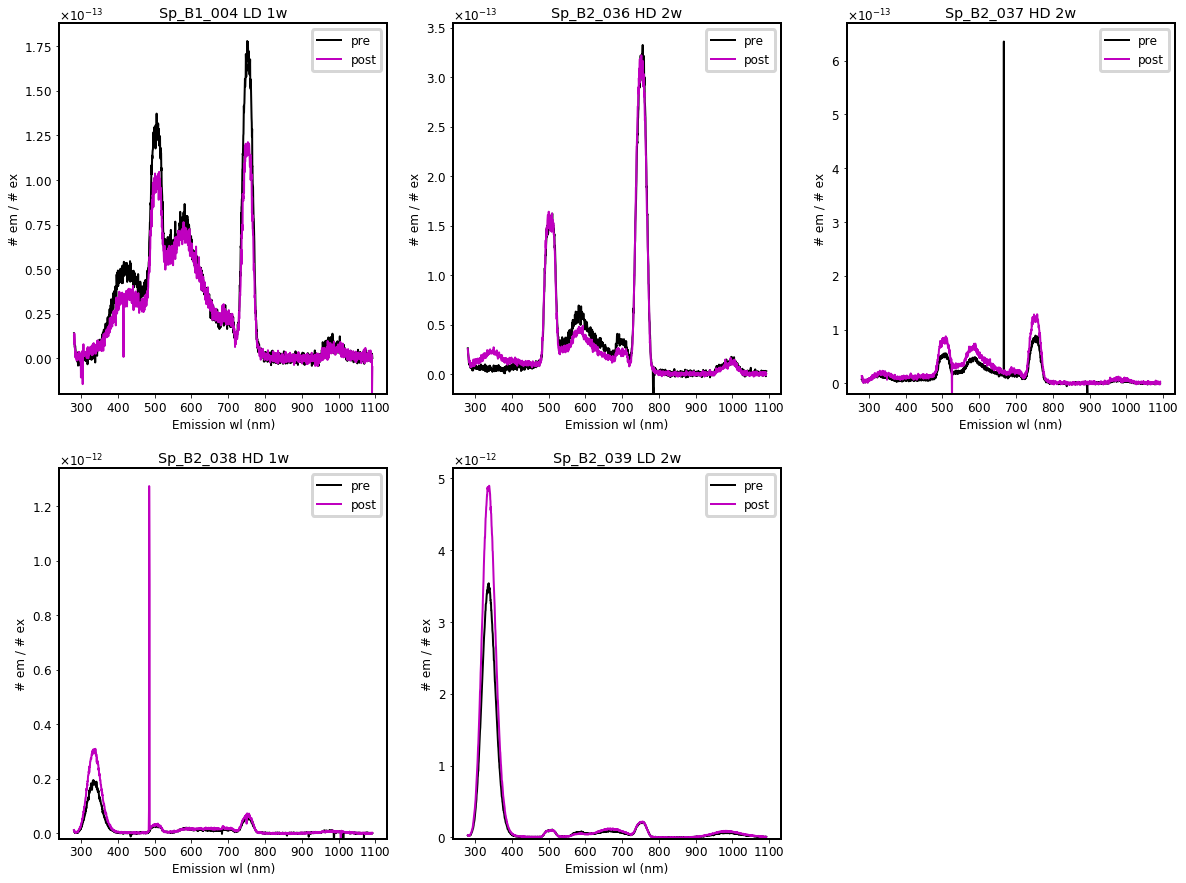

In [11]:
plot_pre_post(Sp_pre, Sp_post)

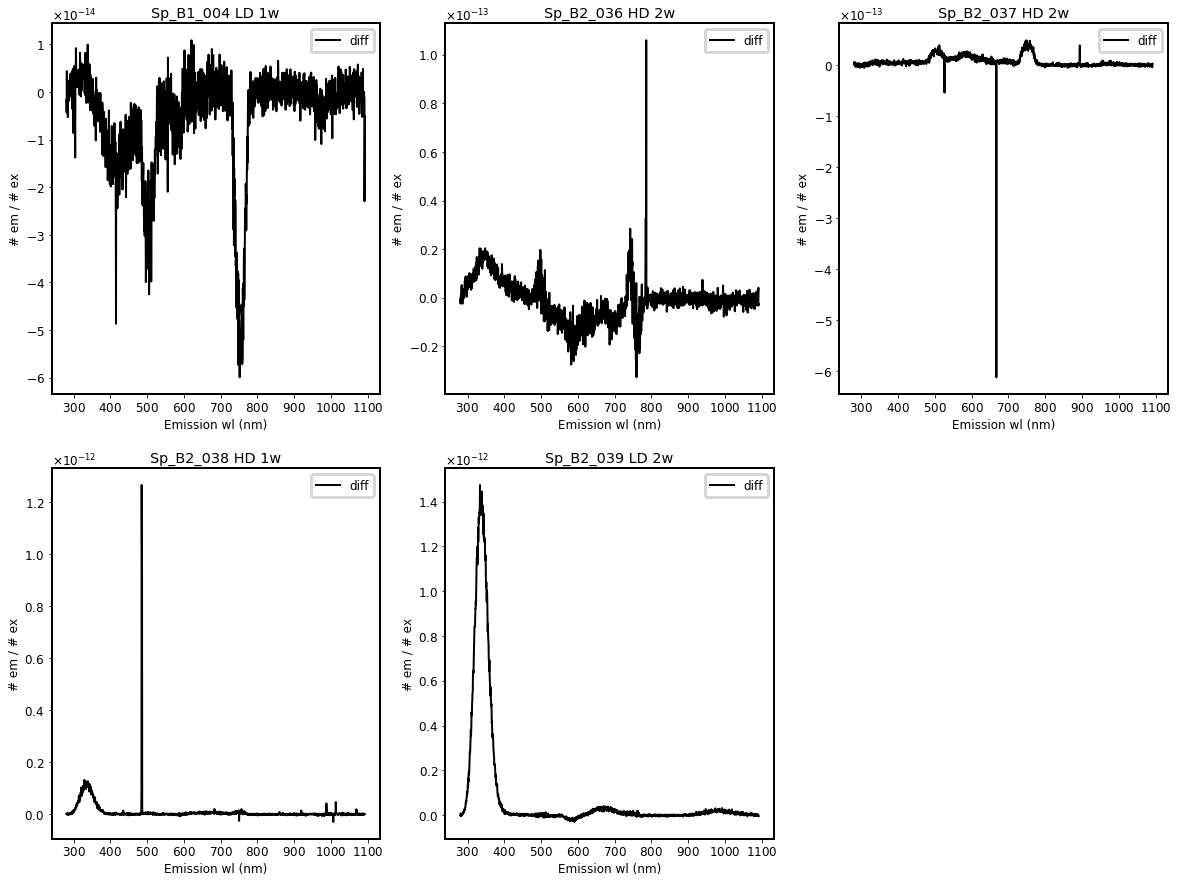

In [12]:
plot_diff(Sp_pre, Sp_post)

# Qz

In [13]:
Qz_pre  = filter_df(experiment.pre .crystals, crystal_type="Qz", ex_wl=250, grating=1, exposure=10, exp_index=0, looparound=False)
Qz_post = filter_df(experiment.post.crystals, crystal_type="Qz", ex_wl=250, grating=1, exposure=10, exp_index=0, looparound=False)

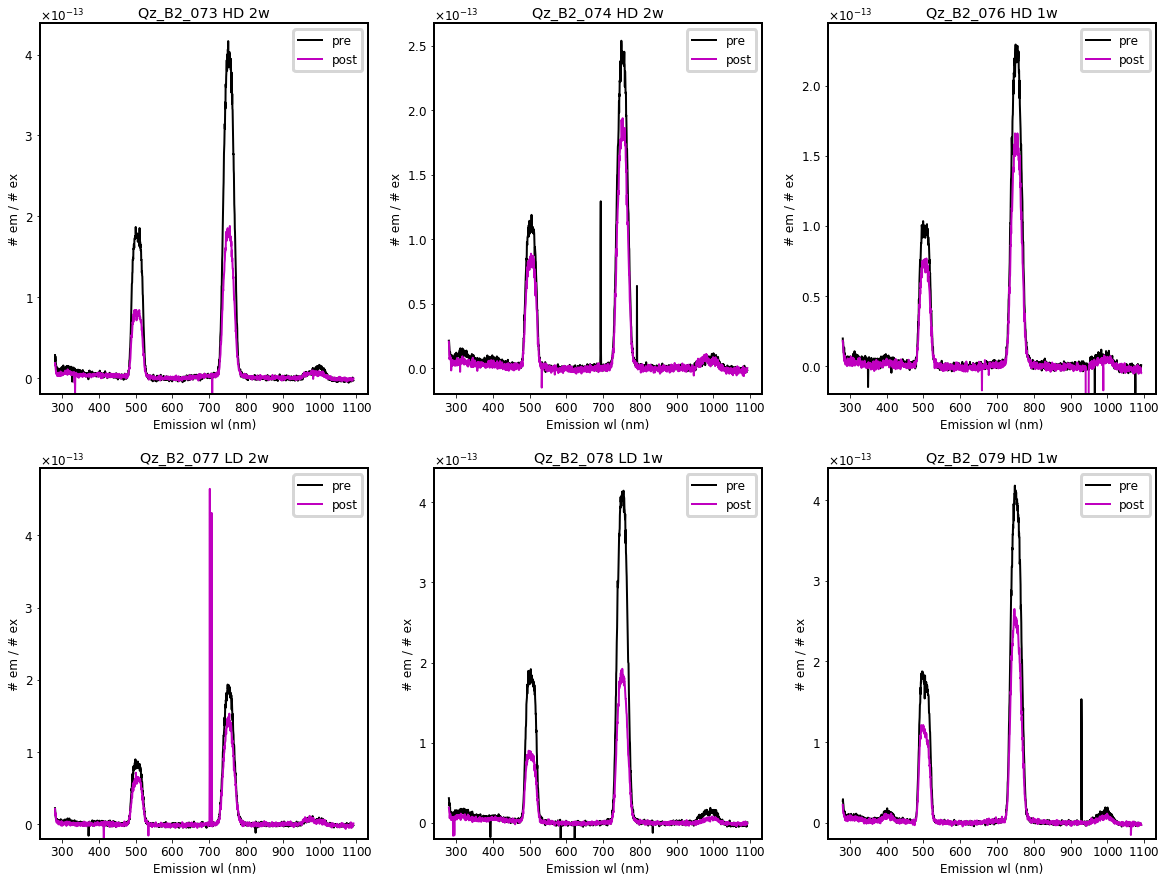

In [14]:
plot_pre_post(Qz_pre, Qz_post)

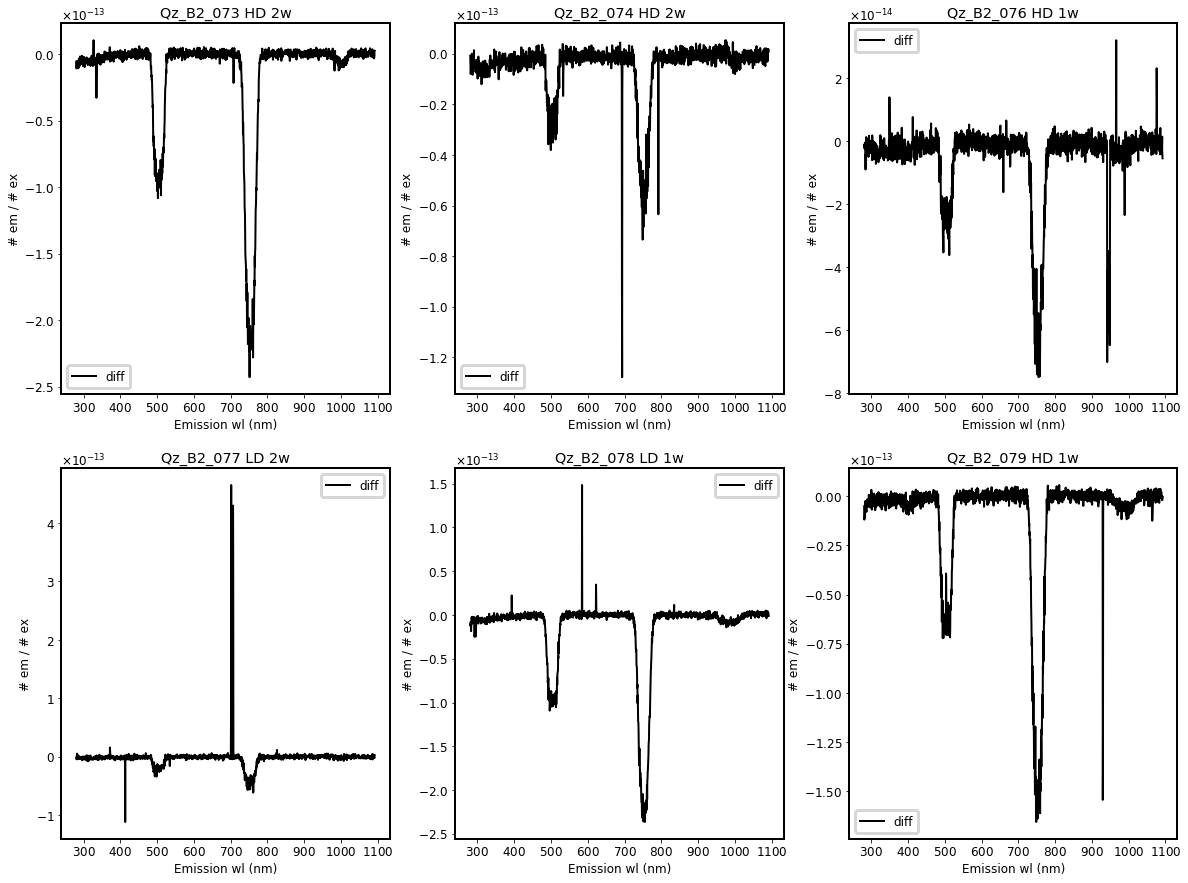

In [15]:
plot_diff(Qz_pre, Qz_post)

# CaF @ 600 nm

In [16]:
CaF600_pre  = filter_df(experiment.pre .crystals, crystal_type="CaF", ex_wl=600, grating=2, exposure=1, exp_index=0, looparound=False)
CaF600_post = filter_df(experiment.post.crystals, crystal_type="CaF", ex_wl=600, grating=2, exposure=1, exp_index=0, looparound=False)

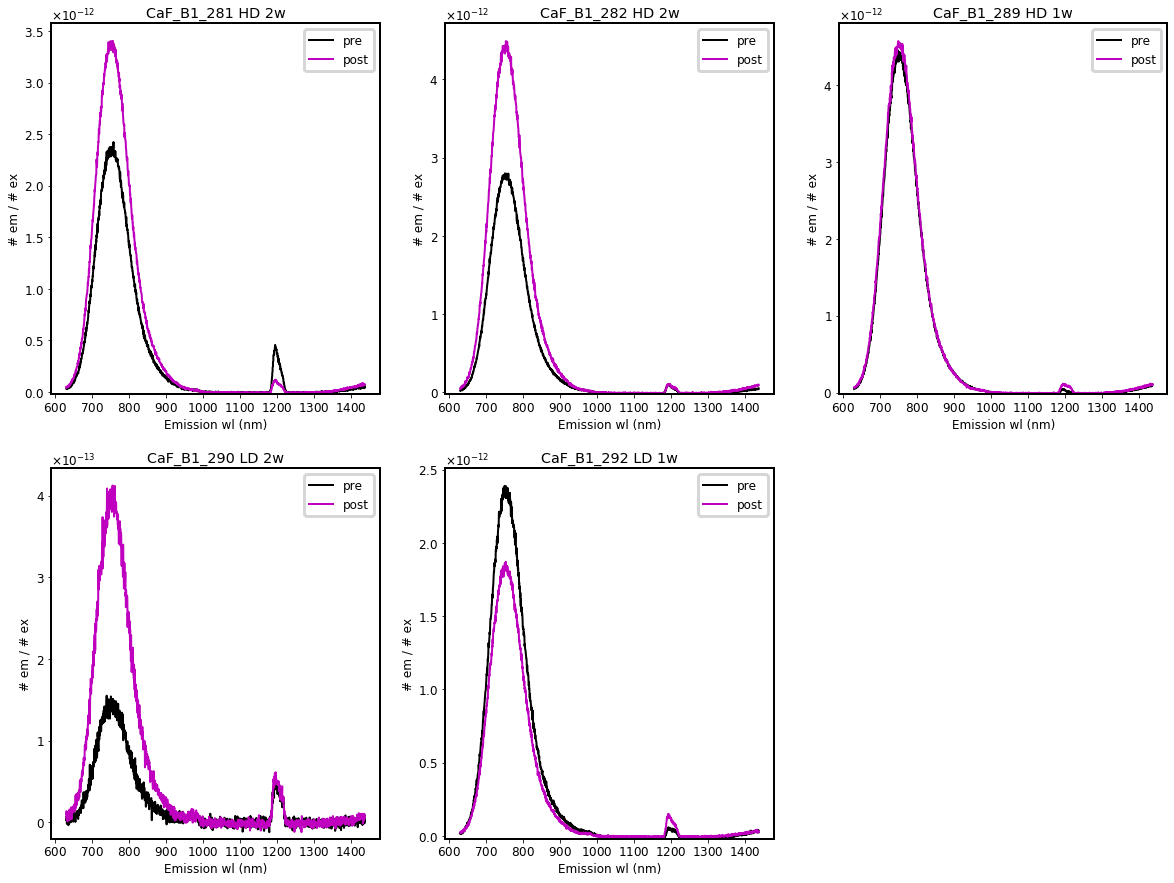

In [17]:
plot_pre_post(CaF600_pre, CaF600_post)

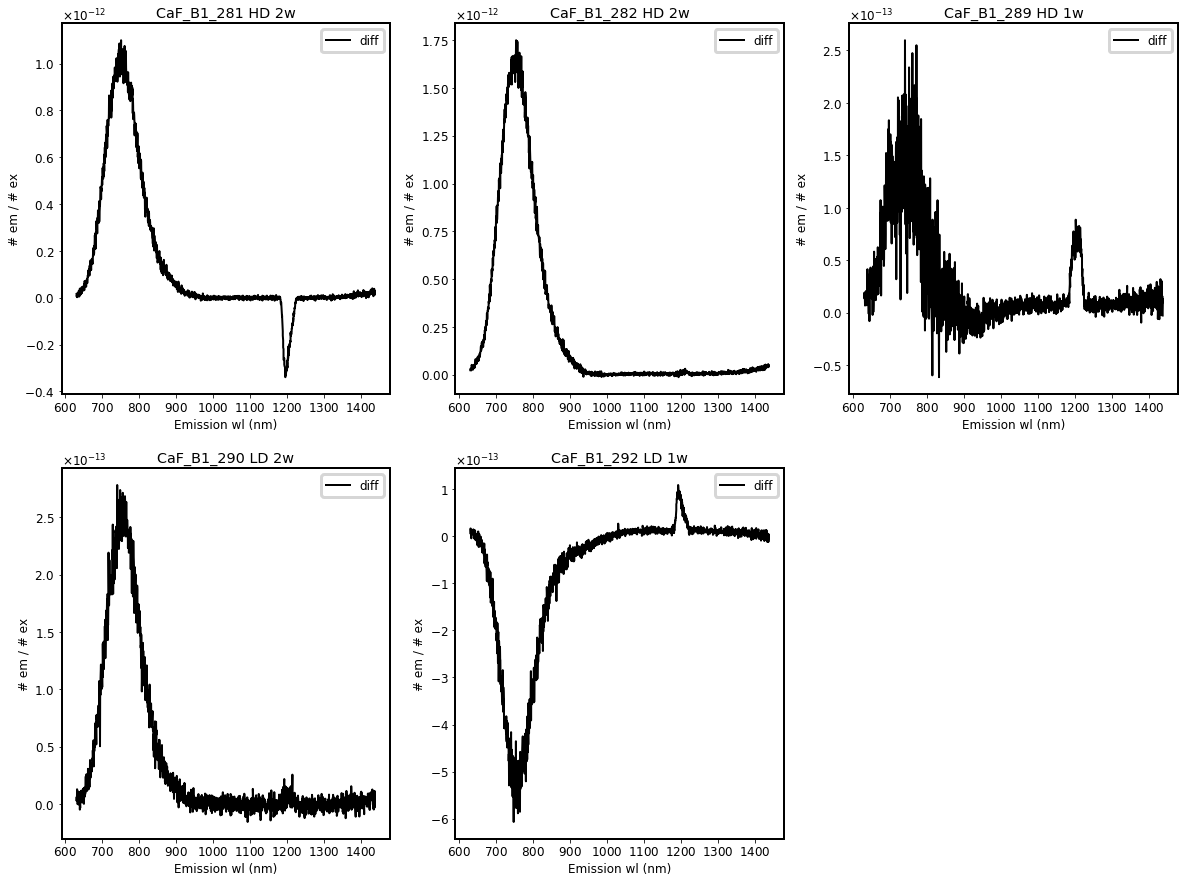

In [18]:
plot_diff(CaF600_pre, CaF600_post)

# CaF @ 410 nm

In [19]:
CaF400_pre  = filter_df(experiment.pre .crystals, crystal_type="CaF", ex_wl=410, grating=2, exposure=1, exp_index=0, looparound=False)
CaF400_post = filter_df(experiment.post.crystals, crystal_type="CaF", ex_wl=410, grating=2, exposure=1, exp_index=0, looparound=False)

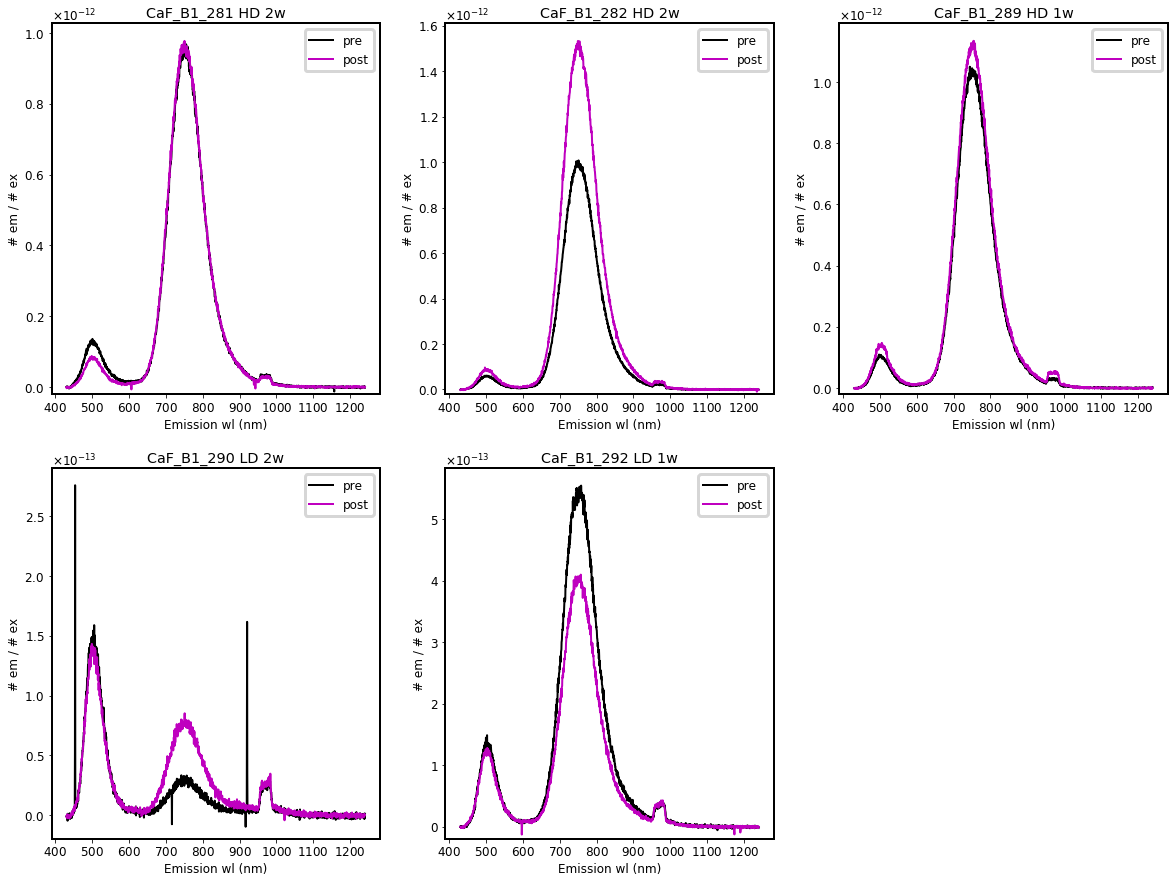

In [20]:
plot_pre_post(CaF400_pre, CaF400_post)

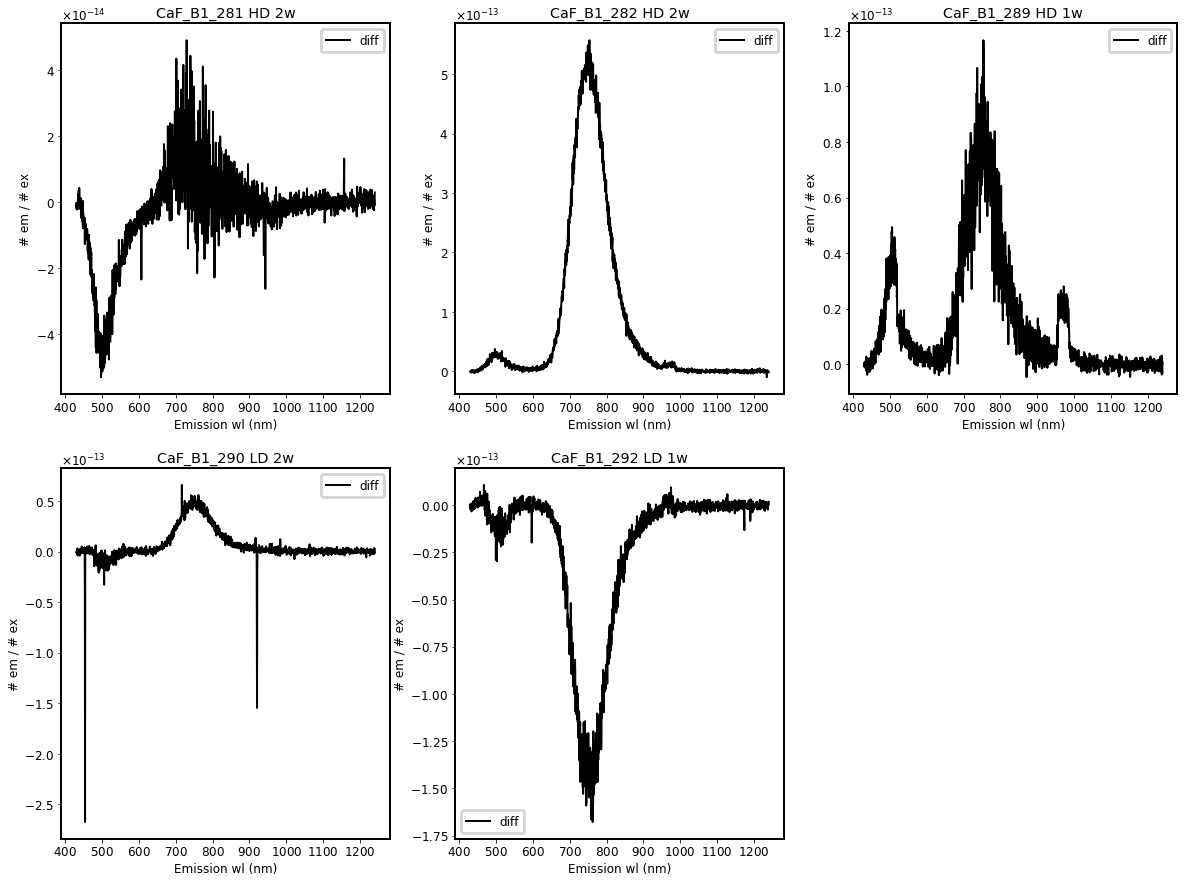

In [21]:
plot_diff(CaF400_pre, CaF400_post)

# CaF @ 400 nm

In [19]:
CaF400_pre  = filter_df(experiment.pre .crystals, crystal_type="CaF", ex_wl=400, grating=2, exposure=10, exp_index=0, looparound=False)
CaF400_post = filter_df(experiment.post.crystals, crystal_type="CaF", ex_wl=400, grating=2, exposure=10, exp_index=0, looparound=False)

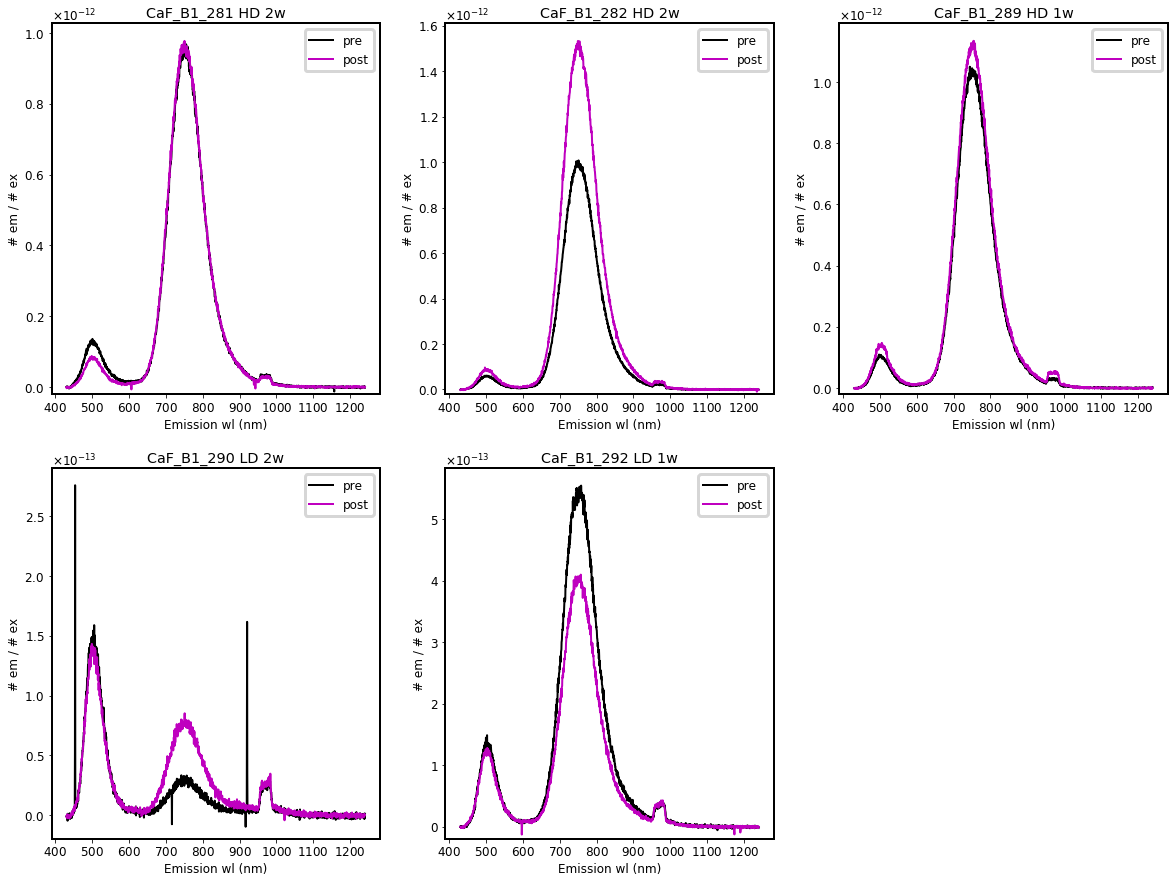

In [20]:
plot_pre_post(CaF400_pre, CaF400_post)

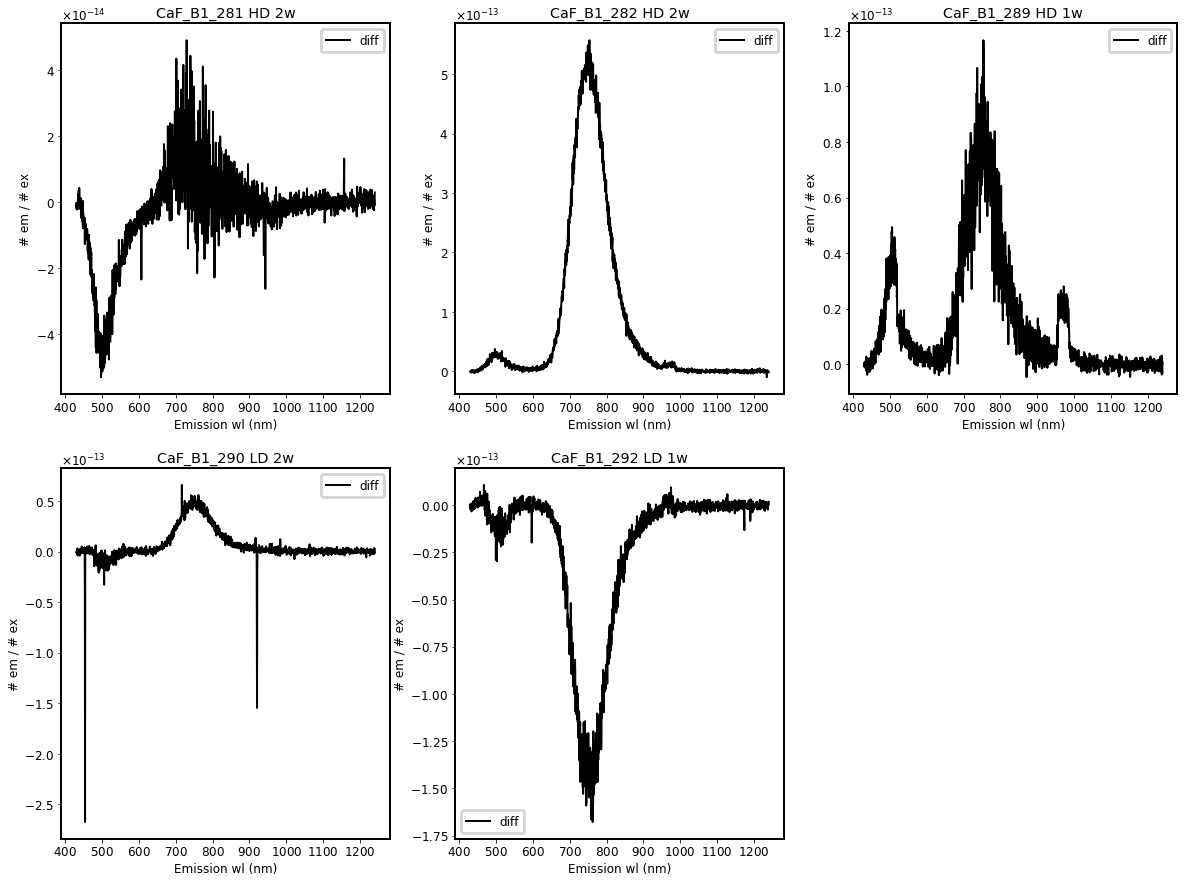

In [21]:
plot_diff(CaF400_pre, CaF400_post)

# CaF @ 350 nm

In [22]:
CaF350_pre  = filter_df(experiment.pre .crystals, crystal_type="CaF", ex_wl=350, grating=1, exposure=10, exp_index=0, looparound=False)
CaF350_post = filter_df(experiment.post.crystals, crystal_type="CaF", ex_wl=350, grating=1, exposure=10, exp_index=0, looparound=False)

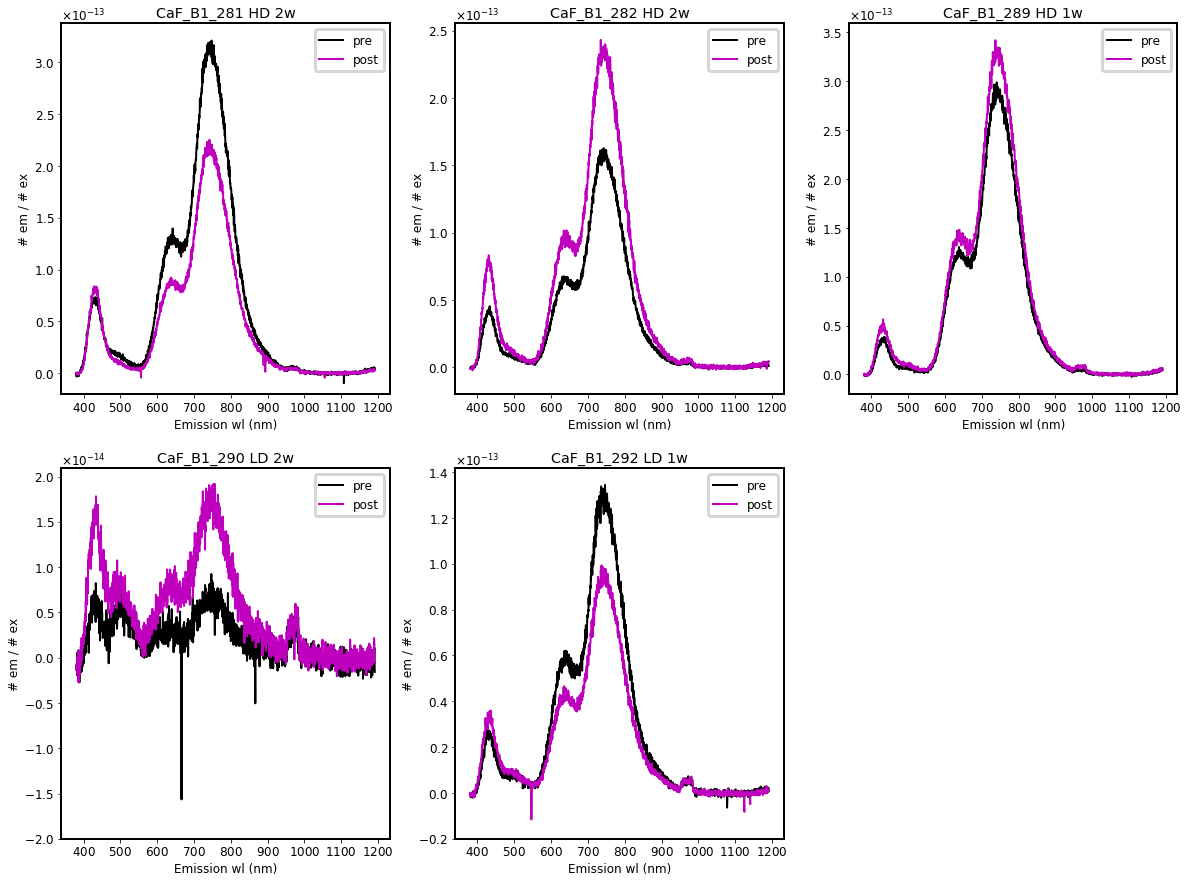

In [23]:
plot_pre_post(CaF350_pre, CaF350_post)

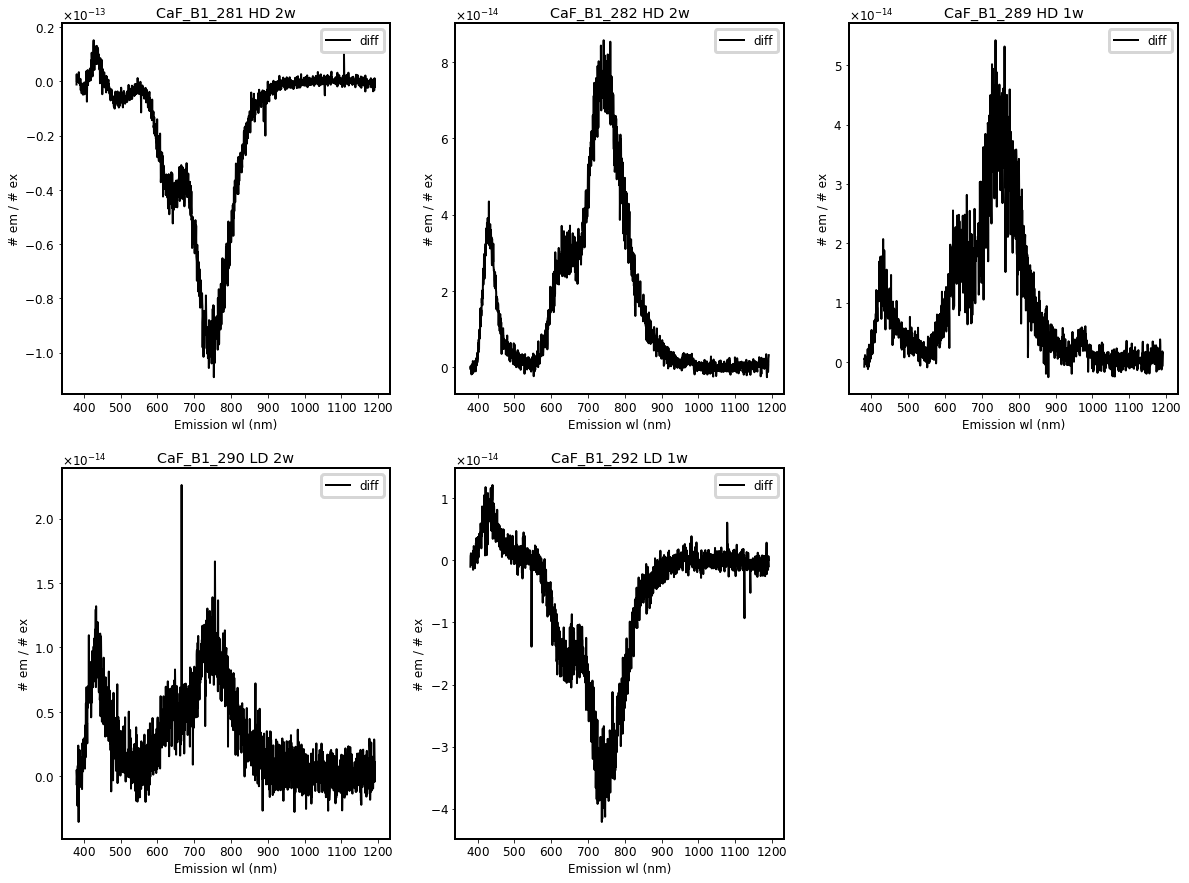

In [24]:
plot_diff(CaF350_pre, CaF350_post)

# BaF @ 250 nm

In [25]:
BaF250_pre  = filter_df(experiment.pre .crystals, crystal_type="BaF", ex_wl=250, grating=1, exposure=10, exp_index=0, looparound=False)
BaF250_post = filter_df(experiment.post.crystals, crystal_type="BaF", ex_wl=250, grating=1, exposure=10, exp_index=0, looparound=False)

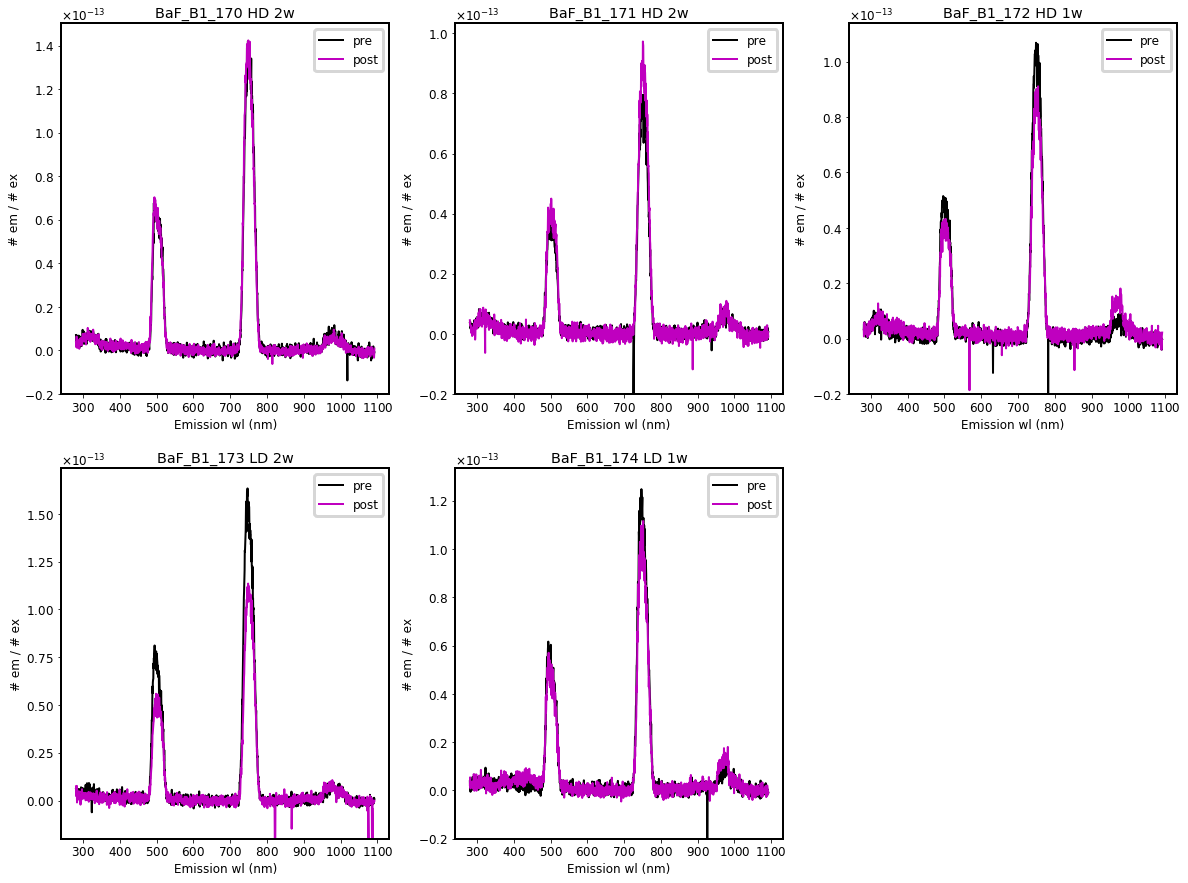

In [26]:
plot_pre_post(BaF250_pre, BaF250_post)

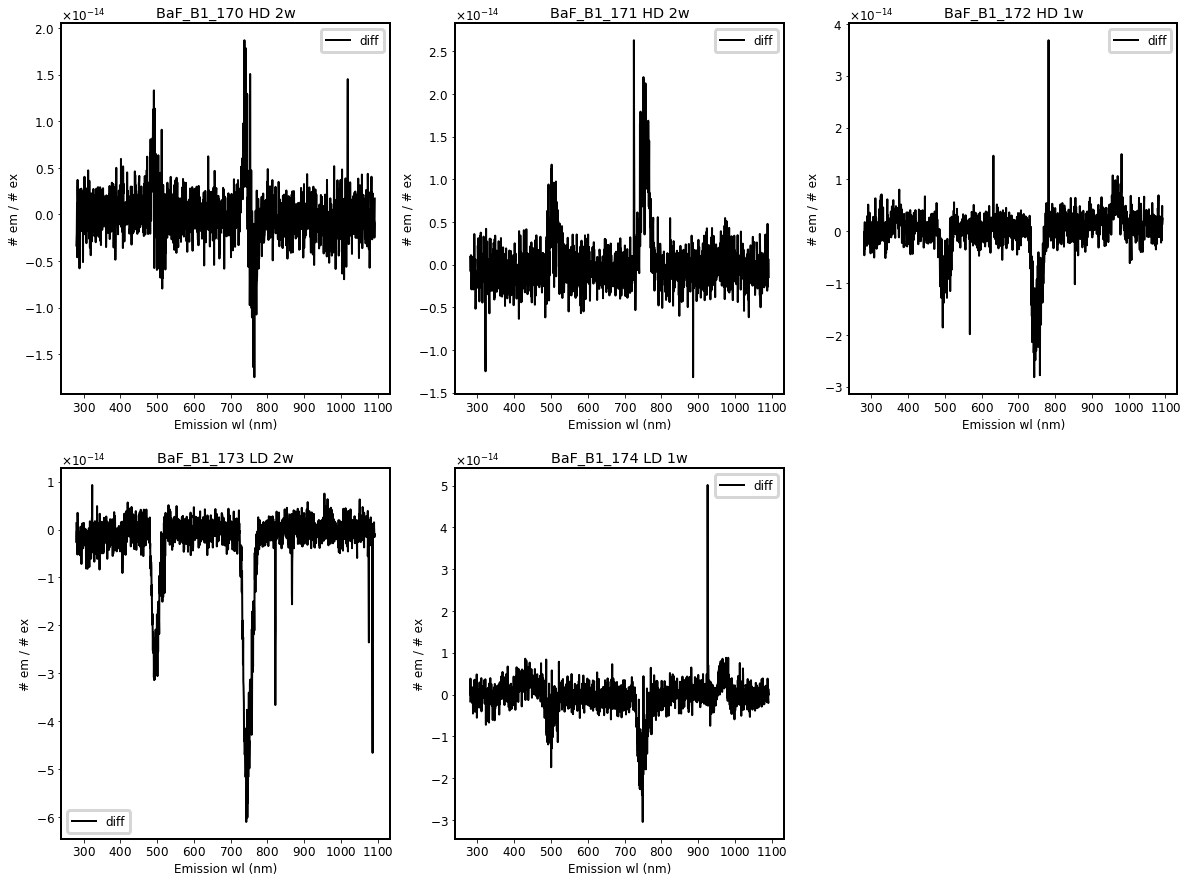

In [27]:
plot_diff(BaF250_pre, BaF250_post)